<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Convolutional-Neural-Networks-in-Python/blob/master/fer_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [0]:
import tensorflow as tf

In [0]:
def init_filter(shape):
  w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
  return w.astype(np.float32)

In [0]:
class convpool():
  def __init__(self, num_feature_maps, num_color_channels, filter_width, filter_height, poolsz=(2, 2)):
    self.poolsz = poolsz
    sz = (filter_width, filter_height, num_color_channels, num_feature_maps)
    W = init_filter(sz)
    b = np.zeros(num_feature_maps, dtype=np.float32)
    
    self.W = tf.Variable(W)
    self.b = tf.Variable(b)
    
    self.params = [self.W, self.b]
    
  def convpool_forward(self, X):
    conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, self.b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

In [0]:
class HiddenLayer():
  def __init__(self, D, M):
    W = np.random.randn(D, M) / np.sqrt(D)
    b = np.zeros(M)
    
    self.W = tf.Variable(W.astype(np.float32))
    self.b = tf.Variable(b.astype(np.float32))
    
    self.params = [self.W, self.b]
  
  def forward(self, X):
    return tf.nn.relu(tf.matmul(X, self.W)+self.b)

In [0]:
class FinalLayer():
  def __init__(self, M, K):
    W = np.random.randn(M, K) / np.sqrt(M)
    b = np.zeros(K)
    
    self.W = tf.Variable(W.astype(np.float32))
    self.b = tf.Variable(b.astype(np.float32))
    
    self.params = [self.W, self.b]
    
  def forward(self, Z):
    return tf.matmul(Z, self.W)+self.b

In [0]:
class CNN():
  def __init__(self, filter_layer_sizes, hidden_layer_sizes):
    self.filter_layer_sizes = filter_layer_sizes
    self.hidden_layer_sizes = hidden_layer_sizes
    
  def set_session(self, session):
    self.session = session
    
  def fit(self, X, Y, lr=1e-2, reg=0.01, training_epochs=5, batch_sz=30):
    
    lr = np.float32(lr)
    reg = np.float32(reg)
    
    X, Y = shuffle(X, Y)
    X = X.astype(np.float32)
    Y = Y.astype(np.int32)
    
    Xtrain, Ytrain = X[:-1000], Y[:-1000]
    Xtest, Ytest = X[-1000:], Y[-1000:]
    
    N = Xtrain.shape[0]
    K = len(set(Ytrain))
    
    num_color_channels = Xtrain.shape[3]
    image_w = Xtrain.shape[1]
    image_h = Xtrain.shape[2]
    
    self.convpool_layers = []
    for num_feature_maps, filter_width, filter_height in self.filter_layer_sizes:
      c = convpool(num_feature_maps, num_color_channels, filter_width, filter_height)
      self.convpool_layers.append(c)
      num_color_channels = num_feature_maps
      image_w = image_w // 2 
      image_h = image_h // 2
      
    self.parameters = []
    for obj in self.convpool_layers:
      self.parameters += obj.params
      
    self.layers = []
    M1 = num_feature_maps * image_w * image_h     # This is now 20 * 12 * 12 = 2880
    for M2 in self.hidden_layer_sizes:
      h = HiddenLayer(M1, M2)
      self.layers.append(h)
      M1 = M2
      
    f = FinalLayer(M1, K)
    self.layers.append(f)
    
    for obj in self.layers:
      self.parameters += obj.params
      
    X = tf.placeholder(tf.float32, shape=(None, 48, 48, 1), name='X')
    Y = tf.placeholder(tf.int32, shape=(None,), name='Y')
    
    logits = self.tf_forward(X)
    
    rcost = reg*sum([tf.nn.l2_loss(p) for p in self.parameters])
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y)) + rcost
    
    train_op = tf.train.MomentumOptimizer(lr, momentum=0.8, use_nesterov=True).minimize(cost)
    
    prediction = tf.argmax(logits, 1)
    
    self.session.run(tf.global_variables_initializer())
    
    n_batches = N // batch_sz
    costs = []
    
    for epoch in range(training_epochs):
      Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        self.session.run(train_op, feed_dict={X:Xbatch, Y:Ybatch})
        
        if j % 20 == 0:
          c, p = self.session.run([cost, prediction], feed_dict={X:Xtest, Y:Ytest})
          costs.append(c)
          e = np.mean(p != Ytest)
          print("Epoch", (epoch + 1), "Batch", j, ": cost =", "%.2f" % c, "error rate =", "%.2f" % e)
  
    plt.plot(costs, label='cost')
    plt.legend()
    plt.show()
    
  def tf_forward(self, X):
    Z = X
    for obj in self.convpool_layers:
      Z = obj.convpool_forward(Z)
    Z = tf.layers.flatten(Z)
    for obj in self.layers:
      Z = obj.forward(Z)
    return Z   

Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 1 Batch 0 : cost = 6.42 error rate = 0.76
Epoch 1 Batch 20 : cost = 6.30 error rate = 0.76
Epoch 1 Batch 40 : cost = 6.20 error rate = 0.76
Epoch 1 Batch 60 : cost = 6.11 error rate = 0.76
Epoch 1 Batch 80 : cost = 6.04 error rate = 0.76
Epoch 1 Batch 100 : cost = 5.94 error rate = 0.76
Epoch 1 Batch 120 : cost = 5.86 error rate = 0.76
Epoch 1 Batch 140 : cost = 5.78 error rate = 0.76
Epoch 1 Batch 160 : cost = 5.70 error rate = 0.76
Epoch 1 Batch 180 : cost = 5.62 error rate = 0.76
Epoch 1 Batch 200 : cost = 5.54 error rate = 0.76
Epoch 1 Batch 220 : cost = 5.46 error rate = 0.76
Epoch 1 Batch 240 : cost = 5.39 error rate = 0.77
Epoch 1 Batch 260 : cost = 5.31 error rate = 0.75
Epoch 1 Batch 280 : cost = 5.26 error rate = 0.80
Epoch 1 Batch 300 : cost = 5.17 error rate = 0.75
Epoch 1 Batch 320 : cost = 5.09 error rate = 0.74
Epoch 1 Batch 340 : cost = 5.01 error rate = 0.71
Epoch 1 Batch 360 : cost = 4.94 error rate = 0.73
Epoch 1 Batch 380 : cost = 4.88 error rate = 0.74
Epoch 

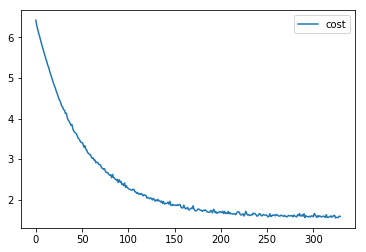

In [24]:
def main():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount = True)

  X = []
  Y = []

  first = True
  for line in open('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/fer2013.csv'):
    if first:
      first = False
    else:
      row = line.split(',')
      Y.append(int(row[0])) # before int it is ['0', '0', '2', '4', '6', '2', '4'], after int it is [0, 0, 2, 4, 6, 2, 4]
      X.append([int(p) for p in row[1].split()])

  X, Y = np.array(X) / 255.0, np.array(Y)

  # balance the 1 class
  X0, Y0 = X[Y!=1, :], Y[Y!=1]
  X1 = X[Y==1, :]
  X1 = np.repeat(X1, 9, axis=0)
  X = np.vstack([X0, X1])
  Y = np.concatenate((Y0, [1]*len(X1)))

  N,D = X.shape
  d = int(np.sqrt(D))
  X = X.reshape(N, d, d, 1)

  model = CNN(
  filter_layer_sizes = [(20, 5, 5), (20, 5, 5)],
  hidden_layer_sizes = [500, 300],
  )

  session = tf.InteractiveSession()
  model.set_session(session)
  model.fit(X, Y)
  
if __name__ == '__main__':
  main()